In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM  # importing layers package , Dense layer is used to connect all layers
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

In [33]:
dataset5 = web.DataReader('^NSEI', data_source='yahoo',start='2015-08-30',end='2022-10-06')
dataset5

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-31,8043.600098,7947.950195,8009.250000,7971.299805,198200.0,7971.299805
2015-09-01,7929.100098,7746.500000,7907.950195,7785.850098,184900.0,7785.850098
2015-09-02,7862.549805,7699.250000,7856.649902,7717.000000,215300.0,7717.000000
2015-09-03,7845.600098,7754.049805,7774.450195,7823.000000,155800.0,7823.000000
2015-09-04,7804.899902,7626.850098,7803.399902,7655.049805,193600.0,7655.049805
...,...,...,...,...,...,...
2022-09-29,17026.050781,16788.599609,16993.599609,16818.099609,340000.0,16818.099609
2022-09-30,17187.099609,16747.699219,16798.050781,17094.349609,376100.0,17094.349609
2022-10-03,17114.650391,16855.550781,17102.099609,16887.349609,278400.0,16887.349609


In [34]:
len(dataset5)

1746

In [35]:
dataset5.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-29,17026.050781,16788.599609,16993.599609,16818.099609,340000.0,16818.099609
2022-09-30,17187.099609,16747.699219,16798.050781,17094.349609,376100.0,17094.349609
2022-10-03,17114.650391,16855.550781,17102.099609,16887.349609,278400.0,16887.349609
2022-10-04,17287.300781,17117.300781,17147.449219,17274.300781,226000.0,17274.300781
2022-10-06,17428.800781,17315.650391,17379.250000,17331.800781,0.0,17331.800781


In [36]:
opn=dataset5[['Open']]

<AxesSubplot:xlabel='Date'>

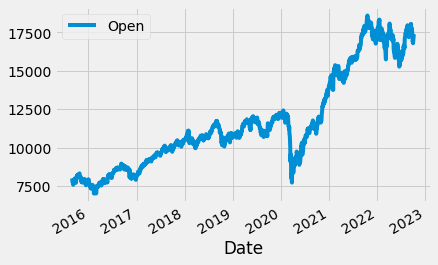

In [37]:
opn.plot()

In [38]:
ds=opn.values

In [39]:
ds

array([[ 8009.25      ],
       [ 7907.95019531],
       [ 7856.64990234],
       ...,
       [17102.09960938],
       [17147.44921875],
       [17379.25      ]])

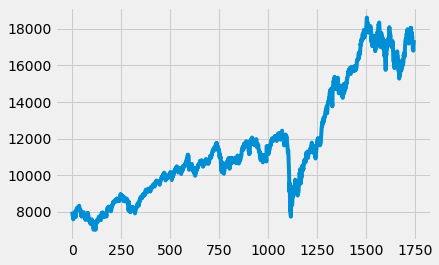

In [40]:
plt.plot(ds)

In [41]:
normalizer=MinMaxScaler(feature_range=(0,1))
ds_scaled=normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [42]:
len(ds_scaled),len(ds)

(1746, 1746)

In [43]:
train_size=int(len(ds_scaled)*0.70)
test_size=len(ds_scaled)-train_size

In [44]:
train_size,test_size

(1222, 524)

In [45]:
ds_train,ds_test=ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [46]:
len(ds_train),len(ds_test)

(1222, 524)

In [47]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [48]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [49]:
X_train.shape,y_train.shape

((1121, 100), (1121,))

In [50]:
X_test.shape, y_test.shape

((423, 100), (423,))

In [51]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [52]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [53]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=95,batch_size=90)

Epoch 1/95
13/13 [==============================] - 11s 320ms/step - loss: 0.0268 - val_loss: 0.1076
Epoch 2/95
13/13 [==============================] - 3s 214ms/step - loss: 0.0043 - val_loss: 0.0234
Epoch 3/95
13/13 [==============================] - 3s 210ms/step - loss: 0.0022 - val_loss: 0.0244
Epoch 4/95
13/13 [==============================] - 3s 220ms/step - loss: 0.0013 - val_loss: 0.0097
Epoch 5/95
13/13 [==============================] - 3s 216ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 6/95
13/13 [==============================] - 3s 206ms/step - loss: 0.0010 - val_loss: 0.0063
Epoch 7/95
13/13 [==============================] - 3s 212ms/step - loss: 0.0010 - val_loss: 0.0087
Epoch 8/95
13/13 [==============================] - 3s 208ms/step - loss: 9.5268e-04 - val_loss: 0.0066
Epoch 9/95
13/13 [==============================] - 3s 215ms/step - loss: 9.3162e-04 - val_loss: 0.0061
Epoch 10/95
13/13 [==============================] - 3s 220ms/step - loss: 8.8509e-04 - val

13/13 [==============================] - 3s 216ms/step - loss: 2.5112e-04 - val_loss: 0.0056
Epoch 80/95
13/13 [==============================] - 3s 220ms/step - loss: 2.4958e-04 - val_loss: 0.0045
Epoch 81/95
13/13 [==============================] - 3s 206ms/step - loss: 2.5756e-04 - val_loss: 0.0055
Epoch 82/95
13/13 [==============================] - 3s 206ms/step - loss: 2.5725e-04 - val_loss: 0.0047
Epoch 83/95
13/13 [==============================] - 3s 213ms/step - loss: 2.5440e-04 - val_loss: 0.0024
Epoch 84/95
13/13 [==============================] - 3s 209ms/step - loss: 2.8949e-04 - val_loss: 0.0020
Epoch 85/95
13/13 [==============================] - 3s 225ms/step - loss: 2.6193e-04 - val_loss: 0.0050
Epoch 86/95
13/13 [==============================] - 3s 218ms/step - loss: 2.5927e-04 - val_loss: 0.0032
Epoch 87/95
13/13 [==============================] - 3s 203ms/step - loss: 2.8167e-04 - val_loss: 0.0057
Epoch 88/95
13/13 [==============================] - 3s 216ms/step 

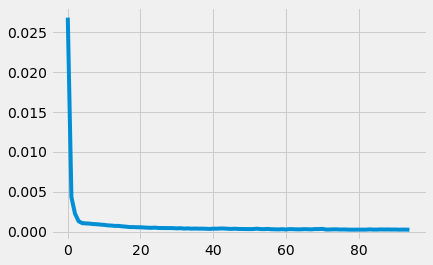

In [54]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [55]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [56]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

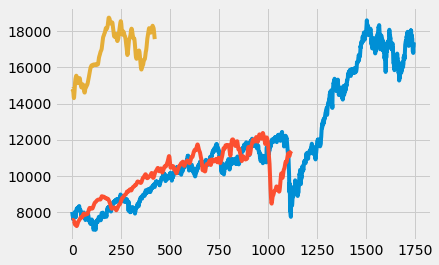

In [57]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled),label= 'Scaled Value')
plt.plot((train_predict),label= 'Training value')
plt.plot((test_predict),label= 'Testing value')

In [58]:
type(train_predict)

numpy.ndarray

In [59]:
test = np.vstack((train_predict,test_predict))

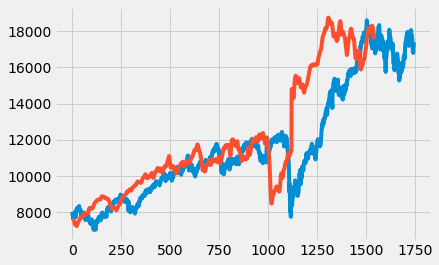

In [60]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [61]:
len(ds_test)

524

In [62]:
#Getting the last 100 days records
fut_inp = ds_test[424:]

In [63]:
fut_inp = fut_inp.reshape(1,-1)

In [64]:
tmp_inp = list(fut_inp)

In [65]:
fut_inp.shape

(1, 100)

In [66]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [67]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9093806743621826], [0.9150452613830566], [0.9229136109352112], [0.93177729845047], [0.9409088492393494], [0.9499304890632629], [0.9586828351020813], [0.9671263098716736], [0.9752784967422485], [0.983180046081543], [0.9908755421638489], [0.998406171798706], [1.0058071613311768], [1.013106346130371], [1.020324945449829], [1.0274780988693237], [1.0345757007598877], [1.0416233539581299], [1.048622727394104], [1.0555733442306519], [1.0624724626541138], [1.0693161487579346], [1.0760995149612427], [1.0828174352645874], [1.0894650220870972], [1.0960373878479004], [1.1025301218032837], [1.108939290046692], [1.1152606010437012], [1.1214921474456787]]


In [68]:
len(ds_scaled)

1746

In [69]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

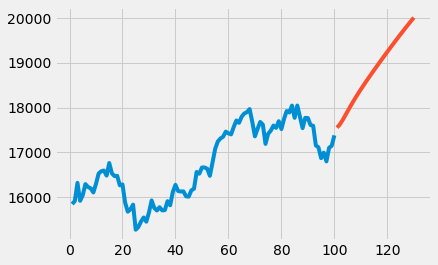

In [70]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1646:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [71]:
ds_new = ds_scaled.tolist()

In [72]:
len(ds_new)

1746

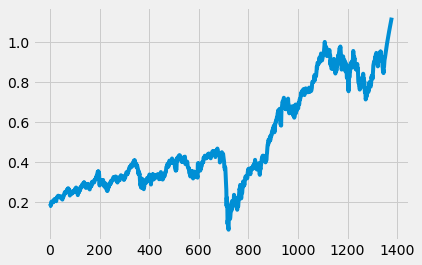

In [73]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[397:])

In [74]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

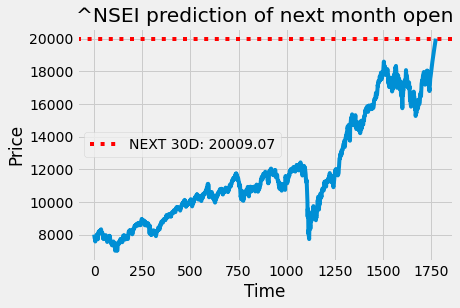

In [75]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format('^NSEI'))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [79]:
for i in range(0,len(final_graph)):
    print(final_graph[i])


[11777.5498046875]
[11464.2998046875]
[11478.5498046875]
[11566.2001953125]
[11354.400390625]
[11359.599609375]
[11378.5498046875]
[11218.599609375]
[11363.2998046875]
[11447.7998046875]
[11540.150390625]
[11487.2001953125]
[11538.4501953125]
[11539.400390625]
[11584.099609375]
[11503.7998046875]
[11301.75]
[11258.75]
[11011.0]
[10910.400390625]
[11140.849609375]
[11288.599609375]
[11244.4501953125]
[11364.4501953125]
[11487.7998046875]
[11603.4501953125]
[11679.25]
[11835.400390625]
[11852.0498046875]
[11973.5498046875]
[11934.650390625]
[11917.400390625]
[12023.4501953125]
[11727.400390625]
[11879.2001953125]
[11861.0]
[11958.5498046875]
[11890.0]
[11957.900390625]
[11937.400390625]
[11807.099609375]
[11922.599609375]
[11633.2998046875]
[11678.4501953125]
[11697.349609375]
[11734.4501953125]
[11783.349609375]
[12062.400390625]
[12156.650390625]
[12399.400390625]
[12556.400390625]
[12680.599609375]
[12702.150390625]
[12659.7001953125]
[12932.5]
[12860.099609375]
[12839.5]
[12813.40039

In [80]:
writer=pd.ExcelWriter('nifty.xlsx')

In [81]:
data1=pd.DataFrame({'Predictions':final_graph})

In [82]:
data1.to_excel(writer)

In [83]:
writer.save()

In [84]:
pwd

'C:\\Users\\36kap\\Downloads'